In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
import pandas as pd

In [8]:
df =pd.read_csv(r"C:\Users\ARNAB\Downloads\Rainfall.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           8425 non-null   object 
 1   Location       8425 non-null   object 
 2   MinTemp        8350 non-null   float64
 3   MaxTemp        8365 non-null   float64
 4   Rainfall       8185 non-null   float64
 5   Evaporation    4913 non-null   float64
 6   Sunshine       4431 non-null   float64
 7   WindGustDir    7434 non-null   object 
 8   WindGustSpeed  7434 non-null   float64
 9   WindDir9am     7596 non-null   object 
 10  WindDir3pm     8117 non-null   object 
 11  WindSpeed9am   8349 non-null   float64
 12  WindSpeed3pm   8318 non-null   float64
 13  Humidity9am    8366 non-null   float64
 14  Humidity3pm    8323 non-null   float64
 15  Pressure9am    7116 non-null   float64
 16  Pressure3pm    7113 non-null   float64
 17  Cloud9am       6004 non-null   float64
 18  Cloud3pm

<Axes: xlabel='RainTomorrow', ylabel='count'>

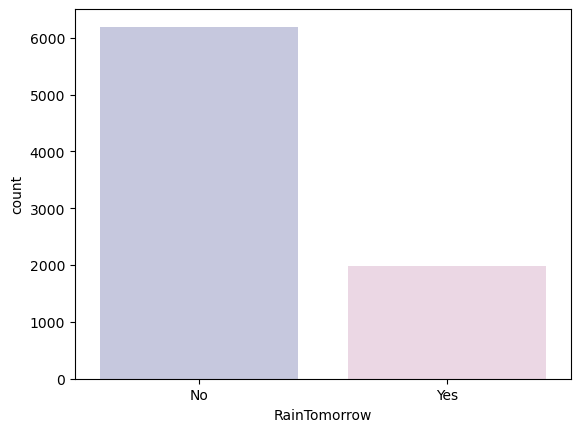

In [11]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#C2C4E2","#EED4E5"]
sns.countplot(x= df["RainTomorrow"], palette= cols)

C:\Users\ARNAB\AppData\Local\Temp\ipykernel_12212\3929058859.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


<Axes: >

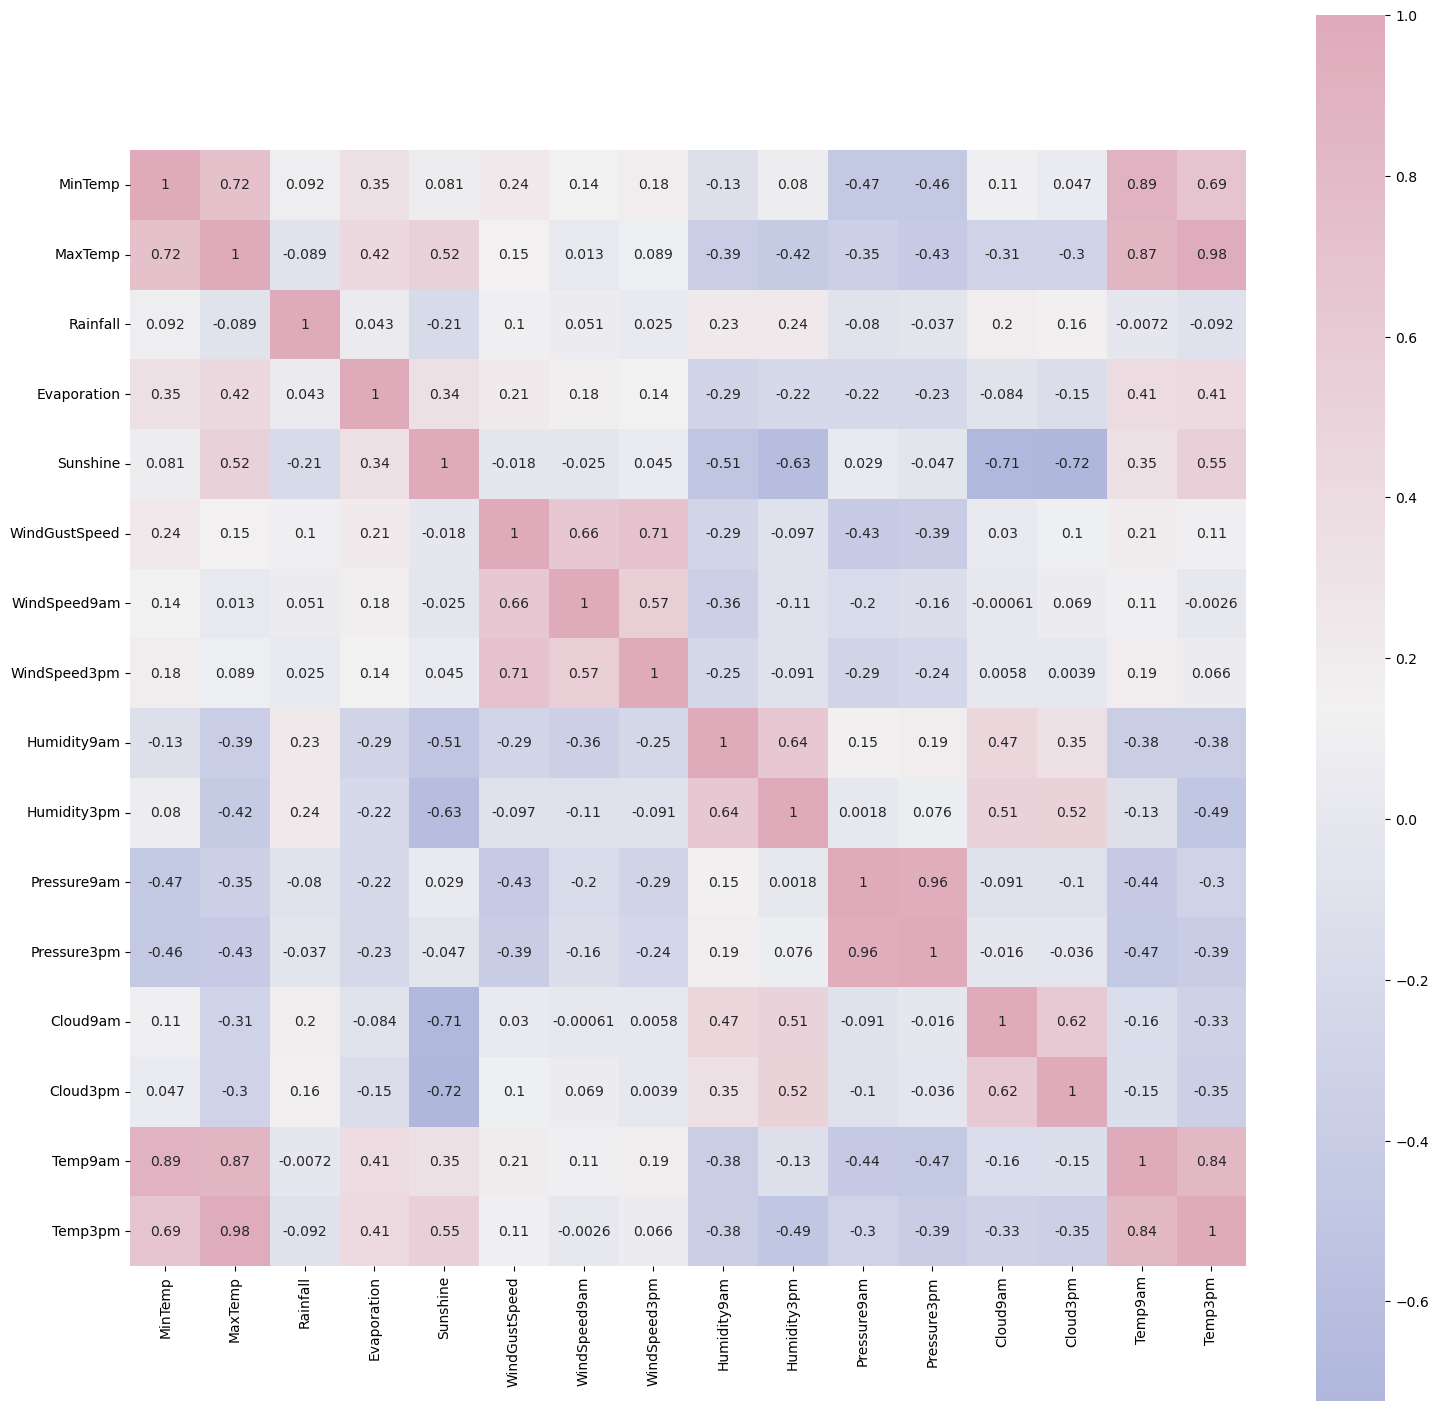

In [12]:
# Correlation amongst numeric attributes
corrmat = df.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [13]:
#Parsing datetime
#exploring the length of date objects
lengths = df["Date"].str.len()
lengths.value_counts()

10    8425
Name: Date, dtype: int64

In [17]:
import numpy as np

In [18]:
#There don't seem to be any error in dates so parsing values into datetime
df['Date']= pd.to_datetime(df["Date"])
#Creating a collumn of year
df['year'] = df.Date.dt.year

# function to encode datetime into cyclic parameters. 
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature. 

def encode(data, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return df

df['month'] = df.Date.dt.month
df = encode(df, 'month', 12)

df['day'] = df.Date.dt.day
df = encode(df, 'day', 31)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

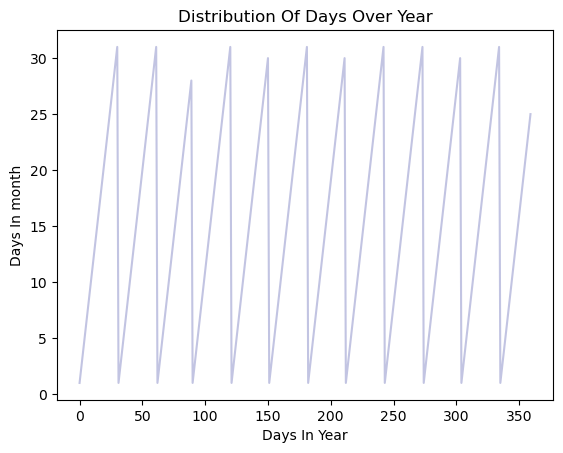

In [20]:
# roughly a year's span section 
section = df[:360] 
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

In [46]:
# Get list of categorical variables
s = (df.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [48]:
# Missing values in categorical variables

for i in object_cols:
    print(i, df[i].isnull().sum())

Location 0
WindGustDir 991
WindDir9am 829
WindDir3pm 308
RainToday 240
RainTomorrow 239


In [50]:
# Filling missing values with mode of the column in value

for i in object_cols:
    df[i].fillna(df[i].mode()[0], inplace=True)

In [51]:
# Get list of neumeric variables
t = (df.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [53]:
# Missing values in numeric variables

for i in num_cols:
    print(i, df[i].isnull().sum())

MinTemp 75
MaxTemp 60
Rainfall 240
Evaporation 3512
Sunshine 3994
WindGustSpeed 991
WindSpeed9am 76
WindSpeed3pm 107
Humidity9am 59
Humidity3pm 102
Pressure9am 1309
Pressure3pm 1312
Cloud9am 2421
Cloud3pm 2455
Temp9am 56
Temp3pm 96
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [54]:
# Filling missing values with median of the column in value

for i in num_cols:
    df[i].fillna(df[i].median(), inplace=True)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           8425 non-null   datetime64[ns]
 1   Location       8425 non-null   object        
 2   MinTemp        8425 non-null   float64       
 3   MaxTemp        8425 non-null   float64       
 4   Rainfall       8425 non-null   float64       
 5   Evaporation    8425 non-null   float64       
 6   Sunshine       8425 non-null   float64       
 7   WindGustDir    8425 non-null   object        
 8   WindGustSpeed  8425 non-null   float64       
 9   WindDir9am     8425 non-null   object        
 10  WindDir3pm     8425 non-null   object        
 11  WindSpeed9am   8425 non-null   float64       
 12  WindSpeed3pm   8425 non-null   float64       
 13  Humidity9am    8425 non-null   float64       
 14  Humidity3pm    8425 non-null   float64       
 15  Pressure9am    8425 n

In [55]:
Text(0.5, 0, 'Years')

NameError: name 'Text' is not defined

In [57]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    df[i] = label_encoder.fit_transform(df[i])
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           8425 non-null   datetime64[ns]
 1   Location       8425 non-null   int32         
 2   MinTemp        8425 non-null   float64       
 3   MaxTemp        8425 non-null   float64       
 4   Rainfall       8425 non-null   float64       
 5   Evaporation    8425 non-null   float64       
 6   Sunshine       8425 non-null   float64       
 7   WindGustDir    8425 non-null   int32         
 8   WindGustSpeed  8425 non-null   float64       
 9   WindDir9am     8425 non-null   int32         
 10  WindDir3pm     8425 non-null   int32         
 11  WindSpeed9am   8425 non-null   float64       
 12  WindSpeed3pm   8425 non-null   float64       
 13  Humidity9am    8425 non-null   float64       
 14  Humidity3pm    8425 non-null   float64       
 15  Pressure9am    8425 n

In [58]:
# Prepairing attributes of scale data

features = df.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = df['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,8425.0,1.906026e-16,1.000059,-1.831985,-0.883358,0.065269,0.697686,1.646313
MinTemp,8425.0,-1.686748e-16,1.000059,-2.824643,-0.723950,0.019658,0.763266,2.845369
MaxTemp,8425.0,6.342174e-16,1.000059,-2.560539,-0.745132,-0.090932,0.677754,3.539881
Rainfall,8425.0,4.891570e-17,1.000059,-0.264165,-0.264165,-0.264165,-0.186640,35.688028
Evaporation,8425.0,6.072294e-17,1.000059,-1.307110,-0.273889,-0.118906,0.036077,36.147146
Sunshine,8425.0,-6.679523e-16,1.000059,-2.830600,0.090983,0.195325,0.264887,2.003925
WindGustDir,8425.0,5.060245e-17,1.000059,-1.534940,-0.896959,-0.046318,1.016983,1.654964
WindGustSpeed,8425.0,3.879521e-17,1.000059,-2.397328,-0.655733,-0.075202,0.577896,4.859315
WindDir9am,8425.0,2.698797e-17,1.000059,-1.584084,-0.930172,-0.058289,1.031564,1.685476
WindDir3pm,8425.0,2.698797e-17,1.000059,-1.763120,-0.860165,0.042790,0.720006,1.622961


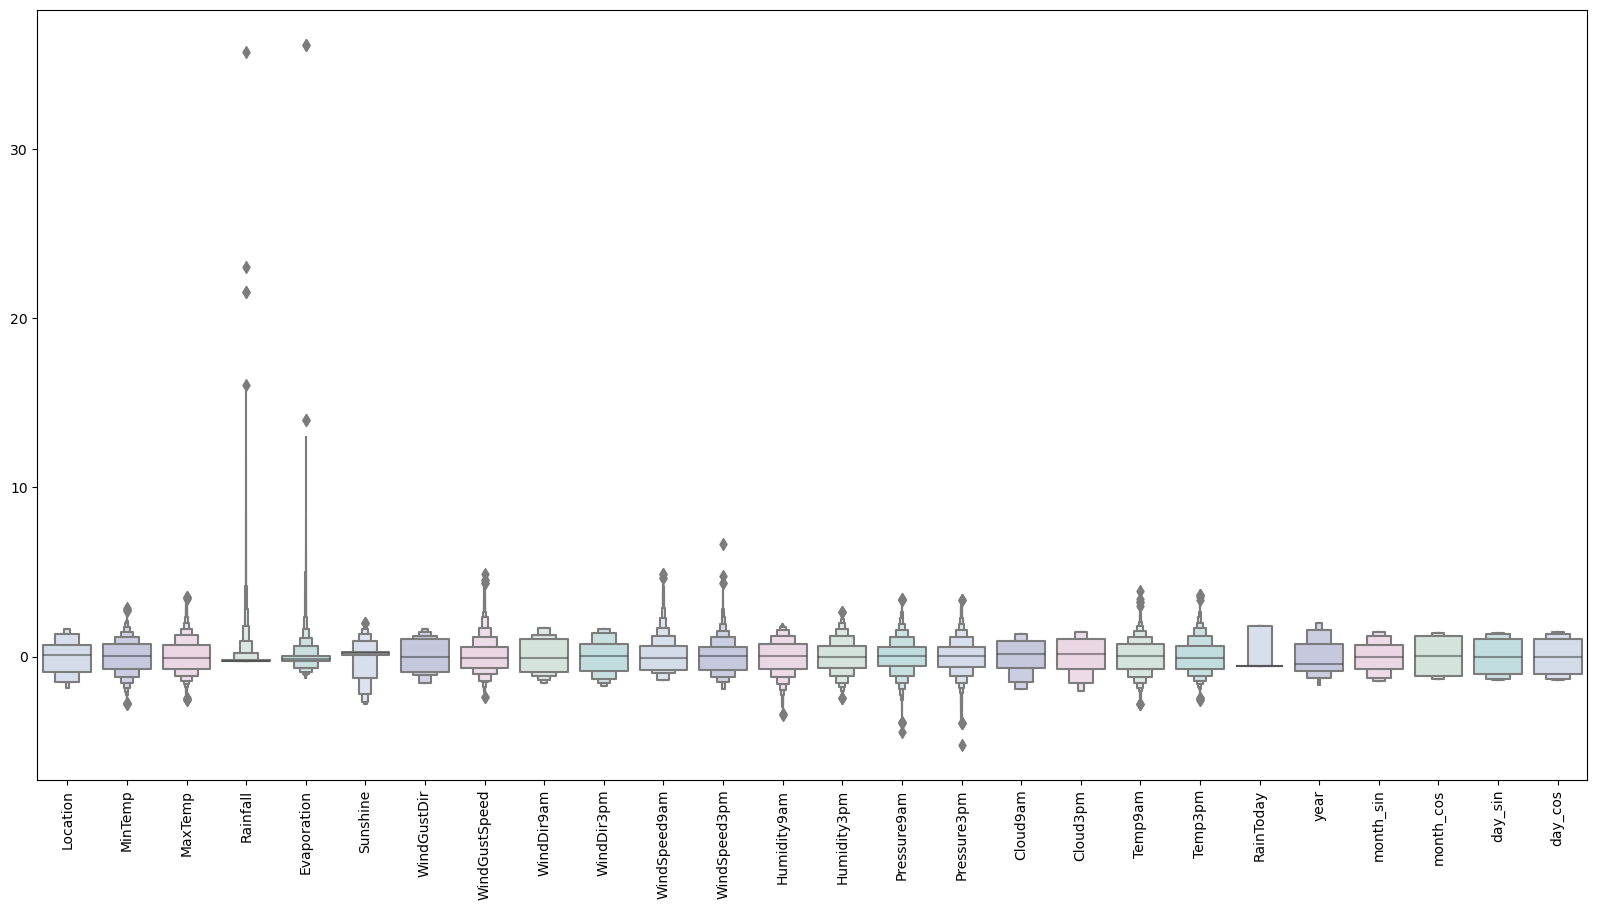

In [59]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [60]:
#full data for 
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(7439, 27)

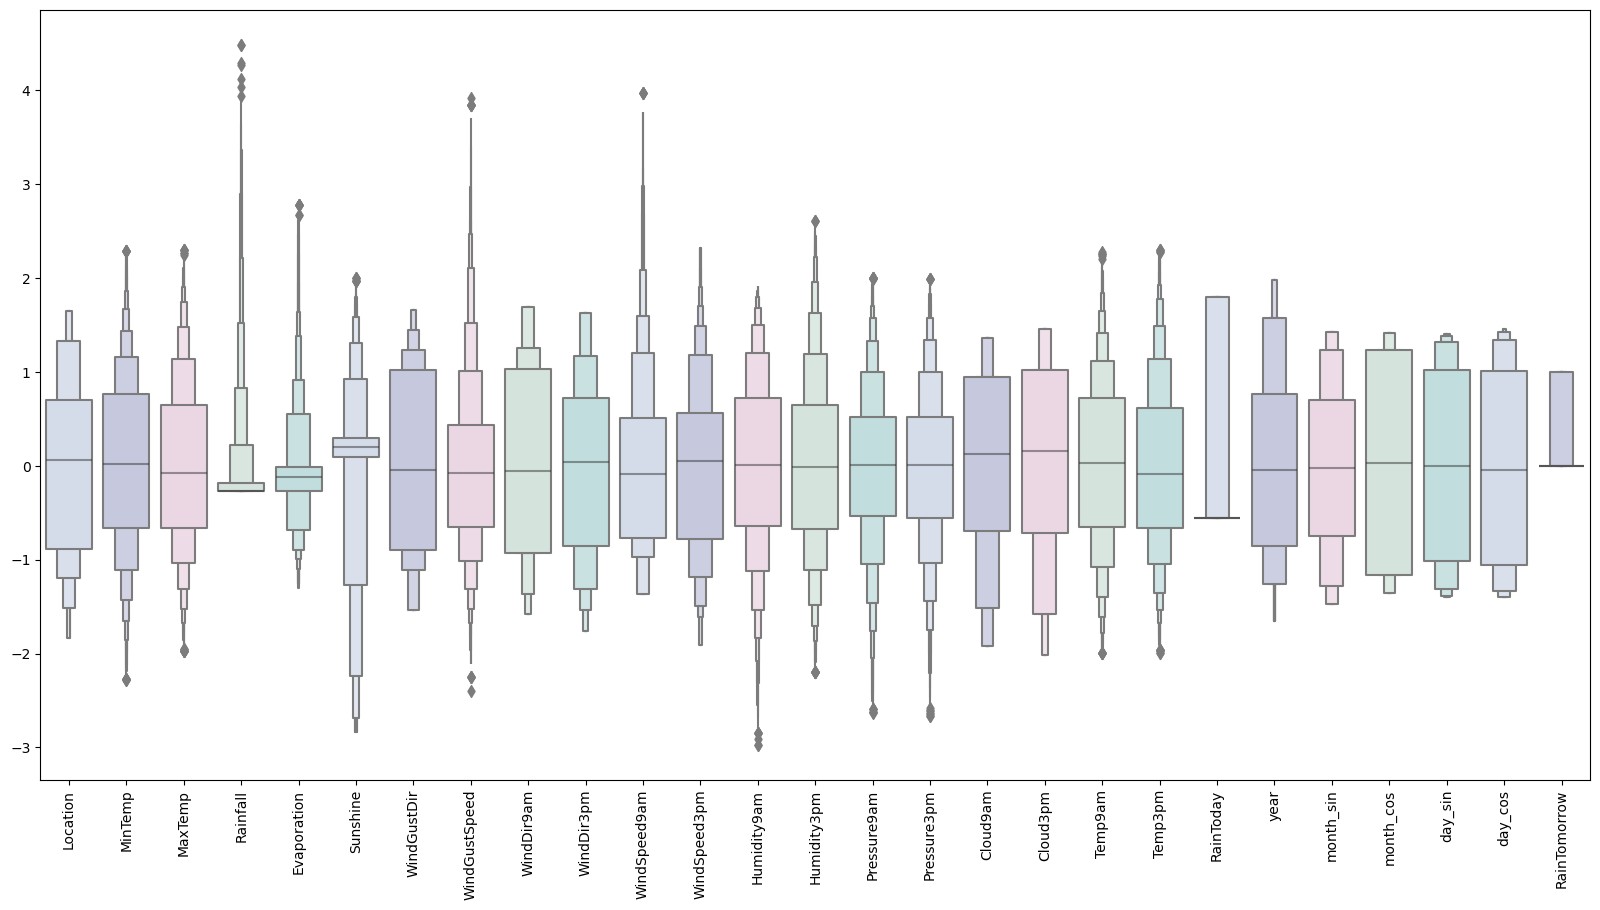

In [61]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [62]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(7439, 26)

In [63]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

C:\Users\ARNAB\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7621 - loss: 0.6922 - val_accuracy: 0.7632 - val_loss: 0.6891
Epoch 2/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7761 - loss: 0.6868 - val_accuracy: 0.7632 - val_loss: 0.6751
Epoch 3/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7591 - loss: 0.6600 - val_accuracy: 0.7632 - val_loss: 0.5779
Epoch 4/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7755 - loss: 0.5387 - val_accuracy: 0.7632 - val_loss: 0.4666
Epoch 5/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7765 - loss: 0.4713 - val_accuracy: 0.7632 - val_loss: 0.4454
Epoch 6/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7650 - loss: 0.4587 - val_accuracy: 0.7632 - val_loss: 0.4386
Epoch 7/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7712 - loss: 0.4474 - val_accuracy: 0.7632 - val_loss: 0.4363
Epoch 8/150
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7690 - loss: 0.4433 - val_accu

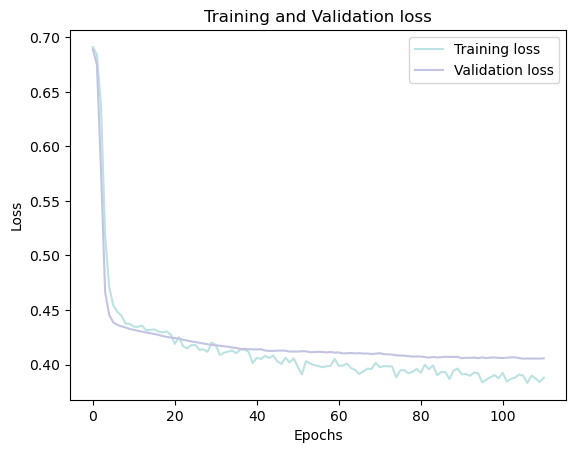

In [64]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

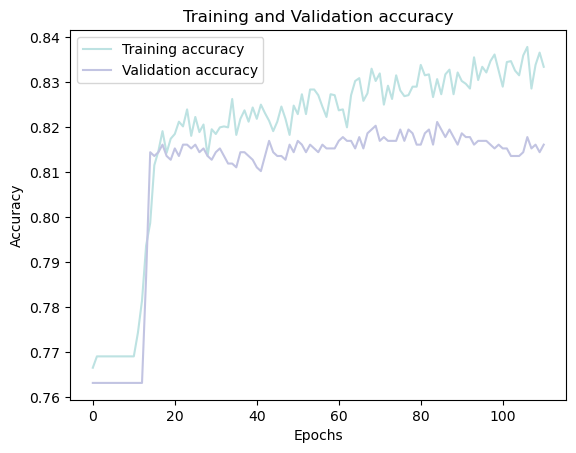

In [65]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [66]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

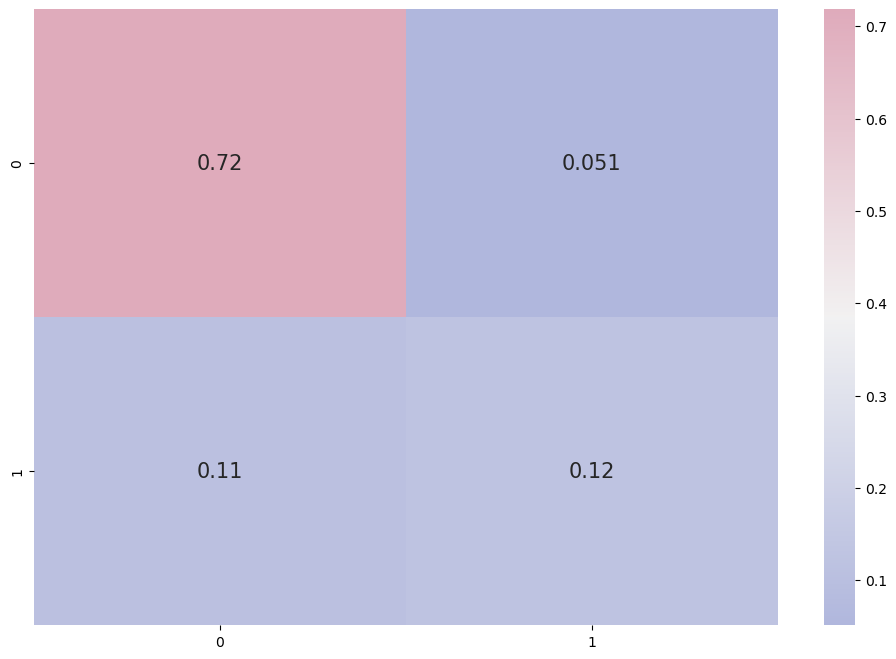

In [67]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1145
           1       0.71      0.53      0.61       343

    accuracy                           0.84      1488
   macro avg       0.79      0.73      0.75      1488
weighted avg       0.83      0.84      0.83      1488

